# 0. Imports

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

import datetime

import matplotlib.pyplot as plt
import optuna
import torch
import torch.optim as optim
from optuna.trial import TrialState
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from tqdm import tqdm

torch.manual_seed(41)

# 1. Dataset Preparation

## 1.1. Data Read In

Processed dataset from [Part 1](https://github.com/johnwslee/fine_dust_analysis) will be used as raw data for study.

In [2]:
df = pd.read_csv(
    "../data/seoul_fine_dust_weather_2008_2021_for_ml.csv",
    index_col=0,
    parse_dates=True,
).reset_index()

In [3]:
df.head()

,date,temp(°C),precipitation(mm),wind_speed(m/s),wind_direction,humidity(%),local_P(hPa),cloud_cover,lowest_ceiling(100m),month,PM10_Counts,PM25_Counts,log_PM10_Counts,log_PM25_Counts
0,2008-01-01 10:00:00,-7.6,0.0,4.6,340.0,47.0,1010.7,2.0,12.0,1,30.0,11.0,3.433987,2.484907
1,2008-01-01 11:00:00,-6.9,0.0,4.1,290.0,42.0,1010.7,2.0,12.0,1,29.0,13.0,3.401197,2.639057
2,2008-01-01 12:00:00,-5.8,0.0,4.1,290.0,42.0,1010.7,2.0,12.0,1,29.0,12.0,3.401197,2.564949
3,2008-01-01 13:00:00,-5.0,0.0,4.1,290.0,36.0,1009.9,0.0,10.0,1,28.0,12.0,3.367296,2.564949
4,2008-01-01 14:00:00,-4.4,0.0,4.1,290.0,36.0,1009.9,0.0,10.0,1,27.0,13.0,3.332205,2.639057


The dataset above will be transformed so that it can be used for multi-scale timeseries classification. In order to do so, `wind_direction`, `humidity(%)`, `lowest_ceiling(100m)`, `temp(°C)`, `wind_speed(m/s)`, `local_P(hPa)`, `precipitation(mm)`, and `PM10_Counts` will be used as features, whereas the binary target, `Air_is_bad?` will be generated based on `PM10_Counts` of the next day.

In [4]:
new_columns = [
    "date",
    "wind_direction",
    "humidity(%)",
    "lowest_ceiling(100m)",
    "temp(°C)",
    "wind_speed(m/s)",
    "local_P(hPa)",
    "precipitation(mm)",
    "PM10_Counts",
]

In [5]:
df = df[new_columns]

In [6]:
df

,date,wind_direction,humidity(%),lowest_ceiling(100m),temp(°C),wind_speed(m/s),local_P(hPa),precipitation(mm),PM10_Counts
0,2008-01-01 10:00:00,340.0,47.0,12.0,-7.6,4.6,1010.7,0.0,30.0
1,2008-01-01 11:00:00,290.0,42.0,12.0,-6.9,4.1,1010.7,0.0,29.0
2,2008-01-01 12:00:00,290.0,42.0,12.0,-5.8,4.1,1010.7,0.0,29.0
3,2008-01-01 13:00:00,290.0,36.0,10.0,-5.0,4.1,1009.9,0.0,28.0
4,2008-01-01 14:00:00,290.0,36.0,10.0,-4.4,4.1,1009.9,0.0,27.0
...,...,...,...,...,...,...,...,...,...
122728,2021-12-31 05:00:00,270.0,39.0,10.0,-7.7,3.5,1018.5,0.0,25.0
122729,2021-12-31 06:00:00,290.0,40.0,10.0,-8.0,3.2,1019.2,0.0,23.0
122730,2021-12-31 07:00:00,270.0,42.0,10.0,-8.6,2.7,1019.9,0.0,22.0
122731,2021-12-31 08:00:00,270.0,42.0,10.0,-8.8,2.9,1020.8,0.0,22.0


Since the time starts from 10 for 2008-01-01, the dataset should start from 2008-01-02 so that all features have equal length of data per day. The same goes for 2021-12-31. So Feature will range from 2008-01-02 to 2021-12-29, while it will be from 2008-01-03 to 2021-12-30 for target.

## 1.2. Target Preparation

In [7]:
df.loc[df["PM10_Counts"] > 45].shape[0]

46562

In [8]:
df.shape[0]

122733

In [9]:
pm10_count = df[["date", "PM10_Counts"]]

In [10]:
pm10_count

,date,PM10_Counts
0,2008-01-01 10:00:00,30.0
1,2008-01-01 11:00:00,29.0
2,2008-01-01 12:00:00,29.0
3,2008-01-01 13:00:00,28.0
4,2008-01-01 14:00:00,27.0
...,...,...
122728,2021-12-31 05:00:00,25.0
122729,2021-12-31 06:00:00,23.0
122730,2021-12-31 07:00:00,22.0
122731,2021-12-31 08:00:00,22.0


In [11]:
pm10_count["date_new"] = pm10_count["date"].dt.date

In [12]:
target = pm10_count.groupby("date_new").mean().reset_index()

In [13]:
target["date_new"] = pd.to_datetime(target["date_new"])

In [14]:
target["Air_is_bad?"] = np.where(target["PM10_Counts"] >= 45, 1, 0)

In [15]:
target = target[["date_new", "Air_is_bad?"]]

In [16]:
target = target.loc[
    (target["date_new"].dt.date >= datetime.date(2008, 1, 3))
    & (target["date_new"].dt.date <= datetime.date(2021, 12, 30))
].reset_index(drop=True)

In [17]:
target

,date_new,Air_is_bad?
0,2008-01-03,1
1,2008-01-04,1
2,2008-01-05,1
3,2008-01-06,1
4,2008-01-07,1
...,...,...
5106,2021-12-26,0
5107,2021-12-27,0
5108,2021-12-28,1
5109,2021-12-29,1


## 1.3. Feature Preparation

The dataframe will be splitted into train and test set based on the year of 2016. The only reason why the data is splited now is to avoid fitting `StandardScaler()` on test data.

In [18]:
train_df = df.loc[df["date"].dt.date < datetime.date(2016, 1, 1)]
test_df = df.loc[df["date"].dt.date >= datetime.date(2016, 1, 1)]

In [19]:
feature_names = list(df.columns[1:])

In [20]:
scaler = StandardScaler()

In [21]:
train_df[feature_names] = scaler.fit_transform(train_df[feature_names])

In [22]:
test_df[feature_names] = scaler.transform(test_df[feature_names])

The train/test df will be concatenated again just for convenience of dataset preparation.

In [23]:
features = pd.concat([train_df, test_df], axis=0)

In [24]:
features["date_new"] = features["date"].dt.date

In [25]:
features = (
    features.groupby("date_new")
    .agg(list)[
        [
            "wind_direction",
            "humidity(%)",
            "lowest_ceiling(100m)",
            "temp(°C)",
            "wind_speed(m/s)",
            "local_P(hPa)",
            "precipitation(mm)",
            "PM10_Counts",
        ]
    ]
    .reset_index()
)

In [26]:
features["date_new"] = pd.to_datetime(features["date_new"])

In [27]:
features = features.loc[
    (features["date_new"].dt.date >= datetime.date(2008, 1, 2))
    & (features["date_new"].dt.date <= datetime.date(2021, 12, 29))
].reset_index(drop=True)

In [28]:
features

,date_new,wind_direction,humidity(%),lowest_ceiling(100m),temp(°C),wind_speed(m/s),local_P(hPa),precipitation(mm),PM10_Counts
0,2008-01-02,"[0.924452475006894, 1.1974764438963235, 1.1974...","[-0.16491600114460359, -0.665906724059201, -0....","[-0.5452500390488106, -0.5452500390488106, -0....","[-1.7379632433239907, -1.62958516404385, -1.53...","[-0.5164077188699413, 0.11713131692002768, 0.1...","[0.9043753409882764, 1.1817998051850536, 1.181...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.32022983414764833, -0.15608473051877228, -..."
1,2008-01-03,"[-1.7147792242575914, -1.2597392761085422, -1....","[-0.06471785656168408, -0.11481692885314383, -...","[-0.22368526895253332, -0.8668148091450879, -0...","[-1.3496084592368196, -1.1870413403166087, -1....","[-1.8538790166487649, -0.6571941712677122, -0....","[1.1187487905948783, 0.7782733118079257, 0.778...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.15608473051877228, 0.19956299401045927, 0...."
2,2008-01-04,"[0.924452475006894, -1.5327632449979716, 1.379...","[0.035480288021235415, -0.01461878427022433, -...","[-0.8668148091450879, -0.8668148091450879, -0....","[-1.2231673667433223, -1.2592933931700356, -1....","[0.046738090721142475, -0.5164077188699413, -1...","[1.1817998051850536, 1.3331222402014657, 1.333...","[-0.11906781300263639, -0.11906781300263639, -...","[0.500495683996732, 1.1570760985122364, 1.4032..."
3,2008-01-05,"[0.7424364957472743, -1.5327632449979716, -1.2...","[-0.6158076517677413, 0.035480288021235415, -0...","[-0.5452500390488106, -0.5452500390488106, -0....","[-1.1328523006765383, -1.12382079406986, -0.97...","[-0.9387670760632539, -0.6571941712677122, -1....","[0.9548161526604138, 0.9043753409882764, 0.904...","[-0.11906781300263639, -0.11906781300263639, -...","[0.500495683996732, 0.9929309948833603, 1.4032..."
4,2008-01-06,"[-1.5327632449979716, -0.8957073175893028, -0....","[0.8871645169760511, 0.5364710109358329, 0.436...","[-0.4380617823500515, -0.974003065843847, -0.9...","[-1.0515687412164327, -0.8619071024761865, -0....","[-1.0091603022621394, -1.0795535284610247, -1....","[0.9548161526604138, 0.9043753409882764, 0.904...","[-0.11906781300263639, -0.11906781300263639, -...","[0.36370809763933537, 1.512723823041468, 1.649..."
...,...,...,...,...,...,...,...,...,...
5106,2021-12-25,"[0.924452475006894, 0.924452475006894, 0.74243...","[-0.4655104348933621, -0.9164020855164998, -1....","[-0.11649701225377423, -0.11649701225377423, -...","[-1.8102152961774178, -2.252759119904659, -2.1...","[1.5953890670966224, 0.609883900312226, 0.6802...","[1.2700712256112905, 2.039293603611432, 2.0392...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.21079976506173095, -0.7853076277627973, -0..."
5107,2021-12-26,"[0.7424364957472743, 0.7424364957472743, 0.924...","[-0.7160057963506608, -0.8162039409335803, -0....","[-0.11649701225377423, -0.11649701225377423, -...","[-2.451452265251584, -2.388231719004835, -2.29...","[-0.3756212664721703, 0.6802771265111115, 0.18...","[2.3671588794803324, 2.518481314496759, 2.4680...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.8126651450342767, -0.9494527313916734, -0...."
5108,2021-12-27,"[1.1974764438963235, -1.2597392761085422, -0.8...","[-0.36531229031044254, -0.31521321801898283, -...","[-0.11649701225377423, -0.11649701225377423, -...","[-2.2437276132979806, -1.9185933754575586, -1....","[-0.23483481407439957, -0.5164077188699413, -0...","[2.1275650240376835, 1.963632386103219, 1.9258...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.8673801795772353, -0.48437493777652446, -0..."
5109,2021-12-28,"[-1.5327632449979716, -1.2597392761085422, -1....","[1.1376598784333498, 1.0374617338504304, 0.636...","[-0.3308735256512924, -0.3308735256512924, -0....","[-1.7199002301106339, -1.6657111904705635, -1....","[-0.30522804027328476, -0.3756212664721703, -0...","[1.7114283277425177, 1.7240385306605557, 1.686...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.18344224

## 1.4. Concatenation of Features and Target

In [29]:
data = pd.concat([features, target["Air_is_bad?"]], axis=1)

In [30]:
data

,date_new,wind_direction,humidity(%),lowest_ceiling(100m),temp(°C),wind_speed(m/s),local_P(hPa),precipitation(mm),PM10_Counts,Air_is_bad?
0,2008-01-02,"[0.924452475006894, 1.1974764438963235, 1.1974...","[-0.16491600114460359, -0.665906724059201, -0....","[-0.5452500390488106, -0.5452500390488106, -0....","[-1.7379632433239907, -1.62958516404385, -1.53...","[-0.5164077188699413, 0.11713131692002768, 0.1...","[0.9043753409882764, 1.1817998051850536, 1.181...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.32022983414764833, -0.15608473051877228, -...",1
1,2008-01-03,"[-1.7147792242575914, -1.2597392761085422, -1....","[-0.06471785656168408, -0.11481692885314383, -...","[-0.22368526895253332, -0.8668148091450879, -0...","[-1.3496084592368196, -1.1870413403166087, -1....","[-1.8538790166487649, -0.6571941712677122, -0....","[1.1187487905948783, 0.7782733118079257, 0.778...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.15608473051877228, 0.19956299401045927, 0....",1
2,2008-01-04,"[0.924452475006894, -1.5327632449979716, 1.379...","[0.035480288021235415, -0.01461878427022433, -...","[-0.8668148091450879, -0.8668148091450879, -0....","[-1.2231673667433223, -1.2592933931700356, -1....","[0.046738090721142475, -0.5164077188699413, -1...","[1.1817998051850536, 1.3331222402014657, 1.333...","[-0.11906781300263639, -0.11906781300263639, -...","[0.500495683996732, 1.1570760985122364, 1.4032...",1
3,2008-01-05,"[0.7424364957472743, -1.5327632449979716, -1.2...","[-0.6158076517677413, 0.035480288021235415, -0...","[-0.5452500390488106, -0.5452500390488106, -0....","[-1.1328523006765383, -1.12382079406986, -0.97...","[-0.9387670760632539, -0.6571941712677122, -1....","[0.9548161526604138, 0.9043753409882764, 0.904...","[-0.11906781300263639, -0.11906781300263639, -...","[0.500495683996732, 0.9929309948833603, 1.4032...",1
4,2008-01-06,"[-1.5327632449979716, -0.8957073175893028, -0....","[0.8871645169760511, 0.5364710109358329, 0.436...","[-0.4380617823500515, -0.974003065843847, -0.9...","[-1.0515687412164327, -0.8619071024761865, -0....","[-1.0091603022621394, -1.0795535284610247, -1....","[0.9548161526604138, 0.9043753409882764, 0.904...","[-0.11906781300263639, -0.11906781300263639, -...","[0.36370809763933537, 1.512723823041468, 1.649...",1
...,...,...,...,...,...,...,...,...,...,...
5106,2021-12-25,"[0.924452475006894, 0.924452475006894, 0.74243...","[-0.4655104348933621, -0.9164020855164998, -1....","[-0.11649701225377423, -0.11649701225377423, -...","[-1.8102152961774178, -2.252759119904659, -2.1...","[1.5953890670966224, 0.609883900312226, 0.6802...","[1.2700712256112905, 2.039293603611432, 2.0392...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.21079976506173095, -0.7853076277627973, -0...",0
5107,2021-12-26,"[0.7424364957472743, 0.7424364957472743, 0.924...","[-0.7160057963506608, -0.8162039409335803, -0....","[-0.11649701225377423, -0.11649701225377423, -...","[-2.451452265251584, -2.388231719004835, -2.29...","[-0.3756212664721703, 0.6802771265111115, 0.18...","[2.3671588794803324, 2.518481314496759, 2.4680...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.8126651450342767, -0.9494527313916734, -0....",0
5108,2021-12-27,"[1.1974764438963235, -1.2597392761085422, -0.8...","[-0.36531229031044254, -0.31521321801898283, -...","[-0.11649701225377423, -0.11649701225377423, -...","[-2.2437276132979806, -1.9185933754575586, -1....","[-0.23483481407439957, -0.5164077188699413, -0...","[2.1275650240376835, 1.963632386103219, 1.9258...","[-0.11906781300263639, -0.11906781300263639, -...","[-0.8673801795772353, -0.48437493777652446, -0...",1
5109,2021-12-28,"[-1.5327632449979716, -1.2597392761085422, -1....","[1.1376598784333498, 1.0374617338504304, 0.636...","[-0.3308735256512924, -0.3308735256512924, -0....","[-1.7199002301106339, -1.6657111904705635, -1....","[-0.30522804027328476, -0.3756212664721703, -0...","[1.7114283277425177, 1.7240385306605557, 1.686...","[-0.11906781300263639, -0.119067

In [31]:
data.to_csv("../data/fine_dust_dataset.csv", index=False)

# 2. DataLoader Preparation

## 2.1. Preparation of X in `numpy.array` format

In [32]:
# To filter out data with inconsistent length

for i in tqdm(range(len(data))):
    for j in range(1, 7):
        if len(data.iloc[i, j]) != 24:
            print(i, j, len(data.iloc[i, j]))
        else:
            continue

 76%|██████████████████████████████████████████████████████████                  | 3907/5111 [00:00<00:00, 5622.51it/s]

2791 1 23
2791 2 23
2791 3 23
2791 4 23
2791 5 23
2791 6 23
2801 1 23
2801 2 23
2801 3 23
2801 4 23
2801 5 23
2801 6 23


100%|████████████████████████████████████████████████████████████████████████████| 5111/5111 [00:00<00:00, 5519.44it/s]


In [33]:
data = data.drop([2791, 2801], axis=0)

In [34]:
feature_array = []
for i in tqdm(range(len(data))):
    row_array = []
    for j in range(1, 9):
        row_array.append(np.array(data.iloc[i, j]))
    stacked_row_array = np.stack(row_array, axis=0)
    feature_array.append(stacked_row_array)

X = np.stack(feature_array, axis=0)

100%|████████████████████████████████████████████████████████████████████████████| 5109/5109 [00:01<00:00, 3618.19it/s]


In [35]:
X.shape

(5109, 8, 24)

## 2.2. Preparation of y in `numpy.array` format

In [36]:
y = np.array(data["Air_is_bad?"])

In [37]:
y.shape

(5109,)

## 2.3. Train/Valid/Test Split for Deep Learning

In [38]:
# To find the index to split the data into train and test set
len(data.loc[data["date_new"].dt.date < datetime.date(2016, 1, 1)])

2919

In [39]:
# To find the index to split the test data into valid and test set
len(data.loc[data["date_new"].dt.date < datetime.date(2018, 1, 1)])

3650

In [40]:
X_train = X[:2919, :, :]
X_valid = X[2919:3650, :, :]
X_test = X[3650:, :, :]

y_train = y[:2919]
y_valid = y[2919:3650]
y_test = y[3650:]

## 2.4. DataLoaders

In [41]:
X_train_tensor = torch.Tensor(X_train)
X_valid_tensor = torch.Tensor(X_valid)
X_test_tensor = torch.Tensor(X_test)

y_train_tensor = torch.Tensor(y_train)
y_valid_tensor = torch.Tensor(y_valid)
y_test_tensor = torch.Tensor(y_test)

In [42]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
trainloader = DataLoader(train_dataset, batch_size=28, shuffle=True)

valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
validloader = DataLoader(valid_dataset, batch_size=10, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
testloader = DataLoader(test_dataset, batch_size=10, shuffle=True)

## 2.5. Sample Check

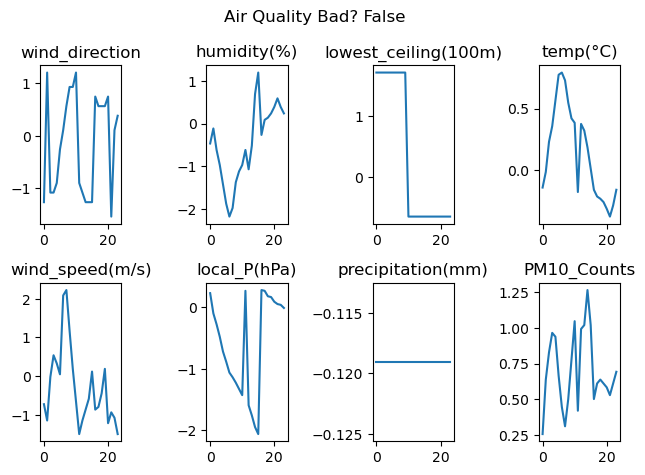

In [43]:
weather, label = next(iter(trainloader))
i = np.random.randint(0, 28)
fig, axs = plt.subplots(nrows=2, ncols=4)
r = 0
c = 0
for j in range(8):
    axs[r, c].plot(weather[i, j, :])
    axs[r, c].set_title(f"{feature_names[j]}")
    if c < 3:
        c += 1
    else:
        r += 1
        c = 0
fig.suptitle(f"Air Quality Bad? {bool(label[i])}")
plt.tight_layout()
plt.show();

## 2.6. DataLoader Save

In [44]:
torch.save(trainloader, "../models/trainloader.pth")
torch.save(validloader, "../models/validloader.pth")
torch.save(testloader, "../models/testloader.pth")